In [1]:
from rl.td import *
from rl.distribution import *
from rl.markov_decision_process import *

# American options imports:
from dataclasses import dataclass, replace
from typing import Callable, Sequence, Tuple, List
import numpy as np
from scipy.stats import norm
from rl.function_approx import \
    DNNApprox, LinearFunctionApprox, FunctionApprox, DNNSpec, AdamGradient
from random import randrange
from numpy.polynomial.laguerre import lagval

## LSPI from rl-book:

#### The basic idea of LSPI is that it does Generalized Policy Iteration (GPI) in the form of Q-Learning with Experience- Replay, with the key being that instead of doing the usual Q-Learning update after each atomic experience, we do batch Q-Learning for the Policy Evaluation phase of GPI. It is an off-policy algorithm, since it utilizes Q-Learning. 

#### Q-Learning differs from SARSA in that the first action is chosen by an exploratory "behavior" policy, and the second action is chosen by the target policy. 

#### transitions are: (s, a, r, s') atomic experiences
#### Update A after each transition step. "Matrix A is accumulated for each TransitionStep (s,a,r,s')
#### Target policy is then just the normal, greedy, argmax over all actions for Q. We get an updated target policy after each transition step has been processed (ie- used to update the wights of outs linear function approximation for the "Q" (action-value) function. See below how the target_policy is updated (using a greedy policy from Q function) after each update to the Q function.

### There are two steps to LSPI: 1) Policy evaluation (using the LSTD Q-value prediction algorithm, aka LSTDQ) and 2) Greedy policy improvement

In [2]:
# Need to pass feature functions because we're must strictly use
# linear function approximation only. 
def least_squares_policy_iteration(
    transitions: Iterable[TransitionStep[S, A]],
    actions: Callable[[NonTerminal[S]], Iterable[A]],
    feature_functions: Sequence[Callable[[Tuple[NonTerminal[S], A]], float]],
    initial_target_policy: DeterministicPolicy[S, A],
    γ: float,
    ε: float
) -> Iterator[LinearFunctionApprox[Tuple[NonTerminal[S], A]]]:
    '''transitions is a finite iterable'''
    target_policy: DeterministicPolicy[S, A] = initial_target_policy
    transitions_seq: Sequence[TransitionStep[S, A]] = list(transitions)
    while True:
        
        # Note how this LSTDQ algorithm reuses the same data D each time
        # ie: it is utilizing Experience Replay
        q: LinearFunctionApprox[Tuple[NonTerminal[S], A]] = \
            least_squares_tdq(
                transitions=transitions_seq,
                feature_functions=feature_functions,
                target_policy=target_policy,
                γ=γ,
                ε=ε,
            )
        target_policy = greedy_policy_from_qvf(q, actions)
        yield q

## LSPI for American Options Pricing

In [3]:
from rl.chapter8.optimal_exercise_bin_tree import *

### LSPI Implementation:

#### pg. 399 at the top: "In the standard variance [LSPI] we described above, sicne D is provided from an external source, the behavior policy that generates this data D must coem from an external source. It doesn't have to be this way - we could generate the experiecnes data from a behavior policy derived from the Q-Value estiamtes produced by LSTDQ (for example, via epsilion-greedy policy)" 

### Scraps of an initial attempt to start from scratch:

In [4]:
# See "Saving your Village from a Vampire" example starting on pg. 400

class LogNormal(SampledDistribution[float]):
    '''A Log Normal distribution with the given μ and σ.'''
    μ: float
    σ: float
    def __init__(self, μ: float, σ: float, expectation_samples: int = 10000):
        self.μ = μ
        self.σ = σ
        super().__init__(
            sampler=lambda: np.random.lognormal(loc=self.μ, scale=self.σ),
            expectation_samples=expectation_samples
        )

@dataclass(frozen=True)
class AmericanOptState:
    history: np.ndarray

class AmericanOptMDP(FiniteMarkovDecisionProcess[AmericanOptState, bool]):
    def __init__(self):
        self.vol = 0.15
        self.starting_price = 1
        super().__init__(self.mdp_map())
        
    # Mapping from State, to Action, to next state and reward
    #def mdp_map(self) -> Mapping[AmericanOptState, Mapping[bool, Categorical[Tuple[AmericanOptState, float]]]]:
    #    return {s

In [5]:
# ?
# Checkout vampire problem on pgs 401-402


transitions = None # lots of atomic experiences in the form of transition steps
actions = None # Do we excercise or do we continue?
feature_functions = None # Jeez what to use here?
initial_target_policy = None # I dunno, uniform continue for all states?
γ = None
ε = None 


## From RL-Book:

In [7]:
TrainingDataType = Tuple[int, float, float]

@dataclass(frozen=True)
class OptimalExerciseRL:

    spot_price: float
    payoff: Callable[[float, float], float]
    expiry: float
    rate: float
    vol: float
    num_steps: int

    # Stock price follows a log normal distribution
    def training_sim_data(
        self,
        num_paths: int,
        spot_price_frac: float
    ) -> Sequence[TrainingDataType]:
        ret: List[TrainingDataType] = []
        dt: float = self.expiry / self.num_steps
        spot: float = self.spot_price
        vol2: float = self.vol * self.vol

        mean2: float = spot * spot
        var: float = mean2 * spot_price_frac * spot_price_frac
        log_mean: float = np.log(mean2 / np.sqrt(var + mean2))
        log_stdev: float = np.sqrt(np.log(var / mean2 + 1))

        for i in range(num_paths):
            price: float = np.random.lognormal(log_mean, log_stdev)
            for step in range(self.num_steps):
                m: float = np.log(price) + (self.rate - vol2 / 2) * dt
                v: float = vol2 * dt
                next_price: float = np.exp(np.random.normal(m, np.sqrt(v)))
                ret.append((step, price, next_price))
                price = next_price
        return ret

    def scoring_sim_data(self, num_paths: int) -> np.ndarray:
        paths: np.ndarray = np.empty([num_paths, self.num_steps + 1])
        dt: float = self.expiry / self.num_steps
        vol2: float = self.vol * self.vol
        for i in range(num_paths):
            paths[i, 0] = self.spot_price
            for step in range(self.num_steps):
                m: float = np.log(paths[i, step]) + (self.rate - vol2 / 2) * dt
                v: float = vol2 * dt
                paths[i, step + 1] = np.exp(np.random.normal(m, np.sqrt(v)))
        return paths

    def adam_gradient(self) -> AdamGradient:
        return AdamGradient(
            learning_rate=0.1,
            decay1=0.9,
            decay2=0.999
        )

    def dnn_func_approx(
        self,
        features: Sequence[Callable[[Tuple[float, float]], float]],
        ds: DNNSpec,
        reg: float
    ) -> DNNApprox[Tuple[float, float]]:
        return DNNApprox.create(
            feature_functions=features,
            dnn_spec=ds,
            adam_gradient=self.adam_gradient(),
            regularization_coeff=reg
        )

    def linear_func_approx(
        self,
        features: Sequence[Callable[[Tuple[float, float]], float]],
        reg: float
    ) -> LinearFunctionApprox[Tuple[float, float]]:
        return LinearFunctionApprox.create(
            feature_functions=features,
            adam_gradient=self.adam_gradient(),
            regularization_coeff=reg
        )

    def train_dql(
        self,
        training_data: Sequence[TrainingDataType],
        init_fa: DNNApprox[Tuple[float, float]],
        training_iters: int
    ) -> DNNApprox[Tuple[float, float]]:
        fa: DNNApprox[Tuple[float, float]] = init_fa
        dt: float = self.expiry / self.num_steps
        gamma: float = np.exp(-self.rate * dt)
        for _ in range(training_iters):
            t_ind, s, s1 = training_data[randrange(len(training_data))]
            t = t_ind * dt
            x_val: Tuple[float, float] = (t, s)
            val: float = self.payoff(t + dt, s1)
            if t_ind < self.num_steps - 1:
                val = max(val, fa.evaluate([(t + dt, s1)])[0])
            y_val: float = gamma * val
            fa = fa.update([(x_val, y_val)])
            # for w in fa.weights:
            #     pprint(w.weights)
        return fa

    def train_lspi(
        self,
        training_data: Sequence[TrainingDataType],
        init_fa: LinearFunctionApprox[Tuple[float, float]],
        training_iters: int,
        split: int
    ) -> LinearFunctionApprox[Tuple[float, float]]:
        fa: LinearFunctionApprox[Tuple[float, float]] = init_fa
        dt: float = self.expiry / self.num_steps
        gamma: float = np.exp(-self.rate * dt)
        num_features: int = len(fa.feature_functions)
        states: Sequence[Tuple[float, float]] = [(i * dt, s) for
                                                 i, s, _ in training_data]
        next_states: Sequence[Tuple[float, float]] = \
            [((i + 1) * dt, s1) for i, _, s1 in training_data]
        features: np.ndarray = fa.get_feature_values(states)
        next_features: np.ndarray = fa.get_feature_values(next_states)
        non_terminal: np.ndarray = np.array(
            [i < self.num_steps - 1 for i, _, _ in training_data]
        )
        exer: np.ndarray = np.array([self.payoff(t1, s1)
                                     for t1, s1 in next_states])
        reg_mat: np.ndarray = fa.regularization_coeff * \
            np.eye(len(fa.feature_functions))
        for i in range(training_iters):
            a_mat: np.ndarray = np.zeros([num_features, num_features])
            b_vec: np.ndarray = np.zeros(num_features)
            cont: np.ndarray = fa.evaluate(next_states)
            cont_cond: np.ndarray = non_terminal * (cont > exer)
            features_split: Sequence[np.ndarray] = \
                np.array_split(features, split)
            next_features_split: Sequence[np.ndarray] = \
                np.array_split(next_features, split, axis=0)
            cont_cond_split: Sequence[np.ndarray] = \
                np.array_split(cont_cond, split)
            exer_split: Sequence[np.ndarray] = np.array_split(exer, split)
            for i in range(split):
                a_mat += features_split[i].T.dot(
                    features_split[i] - np.diag(cont_cond_split[i]).dot(
                        next_features_split[i] * gamma
                    )
                )
                b_vec += features_split[i].T.dot(
                    (1 - cont_cond_split[i]) * exer_split[i] * gamma
                )
            a_mat /= len(training_data)
            a_mat += reg_mat
            b_vec /= len(training_data)
            wts: np.ndarray = np.linalg.solve(a_mat, b_vec)
            fa = replace(
                fa,
                weights=replace(
                    fa.weights,
                    weights=wts
                )
            )
        return fa

    def continuation_curve(
        self,
        func: FunctionApprox[Tuple[float, float]],
        step: int,
        prices: Sequence[float]
    ) -> np.ndarray:
        t: float = step * self.expiry / self.num_steps
        return func.evaluate([(t, p) for p in prices])

    def exercise_curve(
        self,
        step: int,
        prices: Sequence[float]
    ) -> np.ndarray:
        t: float = step * self.expiry / self.num_steps
        return np.array([self.payoff(t, p) for p in prices])

    def put_option_exercise_boundary(
        self,
        func: FunctionApprox[Tuple[float, float]],
        strike: float
    ) -> Sequence[float]:
        ret: List[float] = []
        prices: np.ndarray = np.arange(0., strike + 0.1, 0.1)
        for step in range(self.num_steps):
            cp: np.ndarray = self.continuation_curve(
                func=func,
                step=step,
                prices=prices
            )
            ep: np.ndarray = self.exercise_curve(step=step, prices=prices)
            ll: Sequence[float] = [p for p, c, e in zip(prices, cp, ep)
                                   if e > c]
            ret.append(max(ll) if len(ll) > 0 else 0.)
        final: Sequence[Tuple[float, float]] = \
            [(p, self.payoff(self.expiry, p)) for p in prices]
        ret.append(max(p for p, e in final if e > 0))
        return ret

    def option_price(
        self,
        scoring_data: np.ndarray,
        func: FunctionApprox[Tuple[float, float]]
    ) -> float:
        num_paths: int = scoring_data.shape[0]
        prices: np.ndarray = np.zeros(num_paths)
        dt: float = self.expiry / self.num_steps

        for i, path in enumerate(scoring_data):
            step: int = 0
            while step <= self.num_steps:
                t: float = step * dt
                exercise_price: float = self.payoff(t, path[step])
                continue_price: float = func.evaluate([(t, path[step])])[0] \
                    if step < self.num_steps else 0.
                step += 1
                if exercise_price >= continue_price:
                    prices[i] = np.exp(-self.rate * t) * exercise_price
                    step = self.num_steps + 1

        return np.average(prices)




def fitted_lspi_put_option(
    obj: OptimalExerciseRL,
    strike: float,
    expiry: float,
    training_data: Sequence[TrainingDataType],
    training_iters: int,
    split: int
) -> LinearFunctionApprox[Tuple[float, float]]:

    num_laguerre: int = 3
    lspi_reg: float = 0.001

    ident: np.ndarray = np.eye(num_laguerre)
    features: List[Callable[[Tuple[float, float]], float]] = [lambda _: 1.]
    features += [(lambda t_s, i=i: np.exp(-t_s[1] / (2 * strike)) *
                  lagval(t_s[1] / strike, ident[i]))
                 for i in range(num_laguerre)]
    features += [
        lambda t_s: np.cos(-t_s[0] * np.pi / (2 * expiry)),
        lambda t_s: np.log(expiry - t_s[0]) if t_s[0] != expiry else 0.,
        lambda t_s: (t_s[0] / expiry) ** 2
    ]

    linear_approx: LinearFunctionApprox[Tuple[float, float]] = \
        obj.linear_func_approx(features=features, reg=lspi_reg)

    return obj.train_lspi(
        training_data=training_data,
        init_fa=linear_approx,
        training_iters=training_iters,
        split=split
    )

Generated Training Data
Fitted LSPI Model


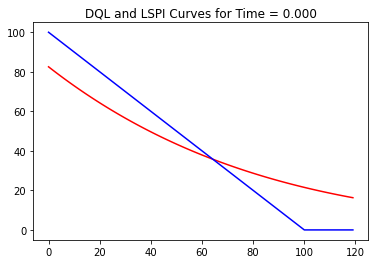

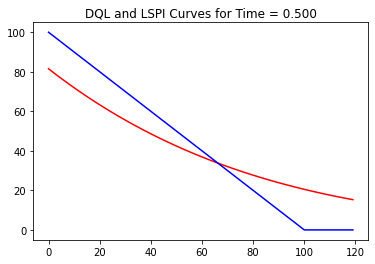

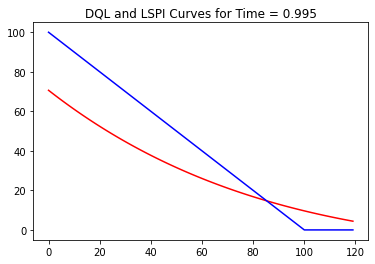

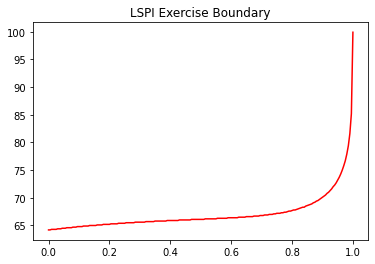

LSPI Option Price = 7.572


In [8]:
import matplotlib.pyplot as plt
spot_price_val: float = 100.0
strike: float = 100.0
expiry_val: float = 1.0
rate_val: float = 0.05
vol_val: float = 0.25
num_steps_val: int = 200

dt: float = expiry_val / num_steps_val

num_training_paths: int = 5000
spot_price_frac_val: float = 0.0

dql_training_iters: int = 1000000
lspi_training_iters: int = 8

split_val: int = 1000

num_scoring_paths: int = 10000

def payoff_func(_: float, s: float) -> float:
    return max(strike - s, 0.)

opt_ex_rl: OptimalExerciseRL = OptimalExerciseRL(
    spot_price=spot_price_val,
    payoff=payoff_func,
    expiry=expiry_val,
    rate=rate_val,
    vol=vol_val,
    num_steps=num_steps_val
)

training_data: Sequence[TrainingDataType] = opt_ex_rl.training_sim_data(
    num_paths=num_training_paths,
    spot_price_frac=spot_price_frac_val
)
print("Generated Training Data")

flspi: LinearFunctionApprox[Tuple[float, float]] = fitted_lspi_put_option(
    obj=opt_ex_rl,
    strike=strike,
    expiry=expiry_val,
    training_data=training_data,
    training_iters=lspi_training_iters,
    split=split_val
)

print("Fitted LSPI Model")

for step in [0, int(num_steps_val / 2), num_steps_val - 1]:
    prices: np.ndarray = np.arange(120.0)
    exer_curve: np.ndarray = opt_ex_rl.exercise_curve(
        step=step,
        prices=prices
    )
    cont_curve_lspi: np.ndarray = opt_ex_rl.continuation_curve(
        func=flspi,
        step=step,
        prices=prices
    )
    plt.plot(
        prices,
        cont_curve_lspi,
        "r",
        prices,
        exer_curve,
        "b"
    )
    time: float = step * expiry_val / num_steps_val
    plt.title(f"DQL and LSPI Curves for Time = {time:.3f}")
    plt.show()


ex_boundary_lspi: Sequence[float] = opt_ex_rl.put_option_exercise_boundary(
    func=flspi,
    strike=strike
)
time_pts: Sequence[float] = [i * dt for i in range(num_steps_val + 1)]
plt.plot(time_pts, ex_boundary_lspi, "r")
plt.title("LSPI Exercise Boundary")
plt.show()

scoring_data: np.ndarray = opt_ex_rl.scoring_sim_data(
    num_paths=num_scoring_paths
)

lspi_opt_price: float = opt_ex_rl.option_price(
    scoring_data=scoring_data,
    func=flspi
)
print(f"LSPI Option Price = {lspi_opt_price:.3f}")

## LSPI option excercise boundary closely resembles that from the binomial tree implementation below. Further, the pricing of the option is very close. 

### Binomial Tree Implementation:

In [9]:
from rl.gen_utils.plot_funcs import plot_list_of_curves
spot_price_val: float = 100.0
strike: float = 100.0
is_call: bool = False
expiry_val: float = 1.0
rate_val: float = 0.05
vol_val: float = 0.25
num_steps_val: int = 300

if is_call:
    opt_payoff = lambda _, x: max(x - strike, 0)
else:
    opt_payoff = lambda _, x: max(strike - x, 0)

opt_ex_bin_tree: OptimalExerciseBinTree = OptimalExerciseBinTree(
    spot_price=spot_price_val,
    payoff=opt_payoff,
    expiry=expiry_val,
    rate=rate_val,
    vol=vol_val,
    num_steps=num_steps_val
)

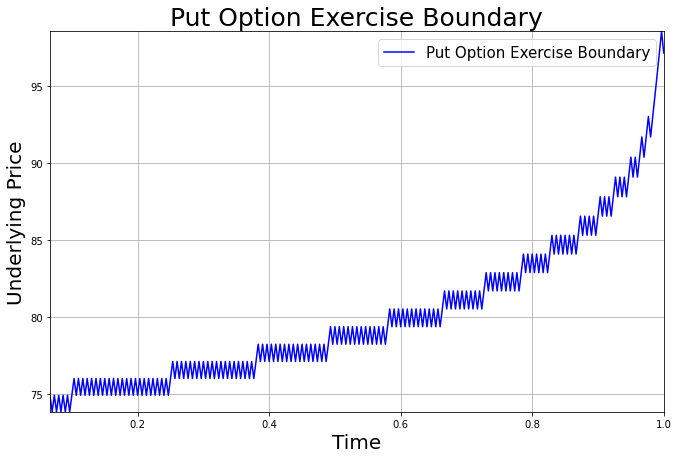

European Price = 7.459
American Price = 7.971


In [10]:
vf_seq, policy_seq = zip(*opt_ex_bin_tree.get_opt_vf_and_policy())
ex_boundary: Sequence[Tuple[float, float]] = \
    opt_ex_bin_tree.option_exercise_boundary(policy_seq, is_call)
time_pts, ex_bound_pts = zip(*ex_boundary)
label = ("Call" if is_call else "Put") + " Option Exercise Boundary"
plot_list_of_curves(
    list_of_x_vals=[time_pts],
    list_of_y_vals=[ex_bound_pts],
    list_of_colors=["b"],
    list_of_curve_labels=[label],
    x_label="Time",
    y_label="Underlying Price",
    title=label
)

european: float = opt_ex_bin_tree.european_price(is_call, strike)
print(f"European Price = {european:.3f}")

am_price: float = vf_seq[0][NonTerminal(0)]
print(f"American Price = {am_price:.3f}")
